## Example of refinement

In [14]:
import json
from random import randint
class demo:
    def __init__(self,path) -> None:
        with open(path,"r") as f:
            self.refine_data=json.load(f)
    def Refine_exmple(self):

        for k,v in self.refine_data.items():
            for k1,v1 in v['Example']['old_prompt'][0].items():
                print(k1)
                print(v1)

            for k1,v1 in v['Example']['new_prompt'][0].items():
                print(k1)
                print(v1)


dd=demo('CAPR/din0s_asqa_r11_withoutPACE.json',)
dd.Refine_exmple()


system_prompt
This is a Long form generation QA task, please provide very long Answer with more details to the question and confidence to the Answer in json.
Instruction
Now, Read the Question and provide very long Answer with more details to the question and confidence to the Answer

Question
What is the name of the trophies awarded at the annual montreal fireworks festival?
input_text

Only give me the reply according to response format, don't give me any other words.

response format :
Answer: [Your final Answer here],
Confidence : [Your final Confidence here]

assit_prompt
Note: The confidence indicates how likely you think your Answer is true and correct,from 0.00 (worst) to 1.00 (best)
system_prompt
This is a Long form generation QA task, provide very long Answer with more details to the question and confidence to the Answer in json
Instruction
"Please provide a detailed and comprehensible answer to the question 'What is thename of the trophy awarded at the yearly Montreal firewo

## Moveing Average of RL

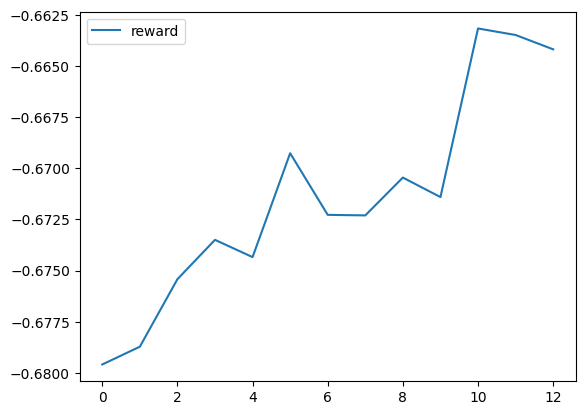

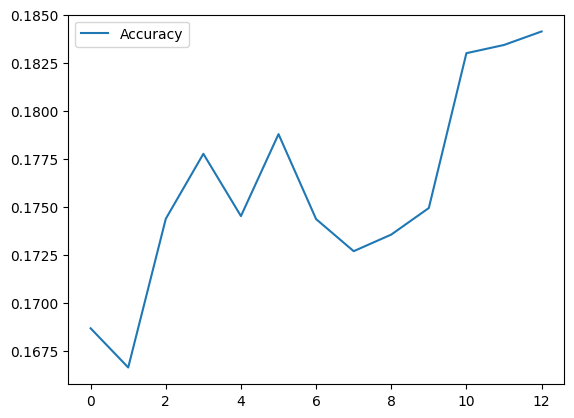

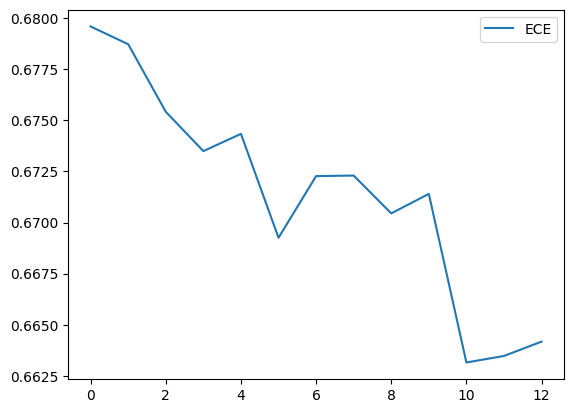

In [20]:
import json
import matplotlib.pyplot as plt


def Moving_average(data_path,label):
    data_size=2
    ratio=0.9
    with open(data_path,'r') as f:
        data=json.load(f)
    movin_avg=sum(data[:data_size])/data_size
    k1=[]
    for i in data:
        movin_avg=ratio*movin_avg+(1-ratio)*i
        k1.append(movin_avg)

    plt.plot(range(len(k1)),k1,label=label,marker='')
    plt.legend()
    plt.show()

for key in ['reward','Accuracy','ECE']:
    p1="CAPR/PPO_State_06122032_vanilla_f1_r12_withPACE"
    Moving_average(f'{p1}/{key}.json',key)



In [ ]:
import torch
from netcal.metrics import ECE
from torch import rand
import numpy as np
def get_ece(y_confs,y_true):
    y_confs=np.array([i.item() for i in y_confs])
    y_true=np.array([i.item() for i in y_true])
    accuracy = np.mean(y_true)
    # y_true=np.where(y_true < accuracy,0,1) ## change to binary ## init 0.59
    # ECE
    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    ece_score = ece.measure(y_confs, y_true)
    # print("ECE:", ece_score)
    return torch.tensor(ece_score)

y_true=rand(size=(128,))/10+0.5
y_conf=rand(size=(128,))/10+0.8

ece=torch.abs(y_true-y_conf)
print(-torch.mean(ece))


## Rouge

In [ ]:
from rouge_score import rouge_scorer
import evaluate
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    print(scores)
    return scores['rougeL'].fmeasure



# Example usage
reference = ["The cat sat on the mat."]
hypothesis = ["The cat sat in the rain"]
scores = [calculate_rouge(i,j) for i,j in zip(reference, hypothesis)]
print(scores)


# rouge=evaluate.load('rouge')

# rouge_results=[rouge.compute(predictiopni,j) for i,j in zip(hypothesis,reference)]
# print(rouge_results)
# print(rouge_results['rougeL'])
# print((rouge_results['rougeL'] > 0.3).astype('int')

In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained("microsoft/deberta-large")

## Get Fig

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json,random,os

# datapath="response_result/20240517/din0s_asqa_gpt-3.5-turbo-0125_cot_Long_QA_gpt-3.5-turbo-0125_bertscore.json"

def get_datapath(dataset,api_model,activate_time,acc_model,sim_model,prompt_strategy,isshuffle_str)-> list:


    task=["QA","Long_QA"]
    datapath=[]
    for i in prompt_strategy:
        for t in task:
            path=f"response_result/{activate_time}/{dataset}_{api_model}_{i}_{t}_{sim_model}_{acc_model}_{isshuffle_str}.json"
            print(path)
            if os.path.isfile(path):
                datapath.append(path)

    return datapath

def mean(data):
    return sum(data)/len(data)

def Load_data(datapath):
    with open(datapath,'r') as f:
        data=json.load(f)

    conf=[i['Confidence'] for i in data]
    ## MAX
    simi=[max(map(float,i['Doc_Ans_simi'])) for i in data]
    ## Mean
    mean_simi=[sum(map(float,i['Doc_Ans_simi']))/len(i['Doc_Ans_simi']) for i in data]
    acc=[i['Accuracy'] for i in data]
    assert len(simi)==len(conf)
    return [conf,mean_simi,acc]

# color=['lightblue','lightred',"lightgreen","yellow",'pink','lightbrown']
def Get_histogram(datalist,dataset,title,stretagy):
# Generate sample data
    # data1 = np.random.normal(0, 1, 1000)
    plt.figure(figsize=(4, 3))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    # assert len(lable)==len(datalist)
    # Plot histograms
    for idx,i in enumerate(datalist):
        plt.hist(i, bins=100, alpha=0.7, label=stretagy[idx],color=colors[idx% len(colors)])
    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{dataset}_{title}")
    plt.legend(loc='upper right')
    plt.xlim([0, 1])
    # plt.ylim([0, 600])
    # Show the plot
    plt.savefig(f"picture/histogram/{dataset}_{title}.png")
    # plt.show()
    plt.clf

def convert_binary_acc(y_true):
    mean_acc=[np.mean(np.array(i)) for i in y_true] ## change to binary

    y_true=[np.where(np.array(i) < mean_acc[idx],0,1) for idx,i in enumerate(y_true)] ## change to binary
    return y_true


def show_histogram_graph(vector,title,File_name,stretagy="",sim="",datafile_name="",label=[]):
    os.makedirs(f"PACE/picture/histogram/{File_name}",exist_ok=True)
    # Plot histogram
    plt.figure(figsize=(4, 3))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    for i,j in zip(vector,label):
        plt.hist(i, bins=100, density=True, alpha=0.7, color=colors[random.randint(0,len(colors)-1)], edgecolor='black',label=j)
    # Add a title and labels
    plt.title(f'{title}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    # plt.ylim(0,1)
    plt.xlim(0,1)
    # Add a grid
    plt.grid(True)
    plt.legend(loc='upper right')
    # Show plot
    plt.savefig(f"PACE/picture/histogram/{File_name}/{datafile_name}.png")
    # plt.show()
    plt.clf

def show_plot_graph(vector,title,File_name,stretagy="",sim="",datafile_name="",label=""):
    os.makedirs(f"PACE/picture/histogram/{File_name}",exist_ok=True)
    # Plot histogram
    plt.figure(figsize=(4, 3))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    # vector=sorted(vector)
    counts, bin_edges = np.histogram(vector, bins=len(vector)//10)

    # 計算每個柱的中心點
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # plt.hist(vector, bins=30, alpha=0.3, color='gray', edgecolor='black')
    plt.plot(bin_centers,counts, marker='.',linestyle='-', color=colors[random.randint(0,len(colors)-1)],label=label)
    # Add a title and labels
    plt.title(f'{title}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    # plt.ylim(0,1)
    # Add a grid
    plt.grid(True)
    plt.legend(loc='upper right')
    # Show plot
    plt.savefig(f"PACE/picture/histogram/{File_name}/{datafile_name}.png")
    # plt.show()
    plt.clf


def Update_Fig(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)

    os.makedirs("PACE/picture/histogram",exist_ok=True)
    simi_models=["Cos_sim"]
    datasets=["din0s/asqa"]
    api_model='gpt-3.5-turbo-0125'
    acc_model='rougeL'

    stretagy=["vanilla",'cot',"multi_step"]

    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_model:
                        print(f"Load Sucess {dataset} {k} {sim}")
                        print(f"Accuracy {np.mean(np.array(dd['Accuracy']))}")
                        print(f"ECE {np.mean(np.array(dd['ece']))}")
                        print(f"AUROC {np.mean(np.array(dd['auroc']))}")
                        dataset_path=dataset.replace("/","_")
                        print(dd['Simi'])
                        show_plot_graph(dd['Conf'],File_name=f"{activate_time}_{isshuffle_str}",title=f"{k} {sim} Confidence",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Confidence",label=f"{isshuffle_str}")

                        show_plot_graph(dd['Simi'],File_name=f"{activate_time}_{isshuffle_str}",title=f"{k} {sim} Similarity",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Similarity",label=f"{isshuffle_str}")

                        show_plot_graph(dd['Pace_Conf'],File_name=f"{activate_time}_{isshuffle_str}",title=f"{k} {sim} Final Confidence",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_PACE_Confidence",label=f"{isshuffle_str}")

                        show_plot_graph(dd['Accuracy'],File_name=f"{activate_time}_{isshuffle_str}",title=f"{k} {sim} Accuracy",stretagy=k,sim=f"{sim}",datafile_name=f"{dataset_path}_{isshuffle_str}_{sim}_{k}_Accuracy",label=f"{isshuffle_str}")

Update_Fig("20240601",False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json,random,os

def show_four_plot(vectorlist,title):
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    random.shuffle(colors)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    fig.patch.set_facecolor('lightgrey')
    # Plot each vector list in its respective subplot
    for i, ax in enumerate(axs.flat):
        counts, bin_edges = np.histogram(vectorlist[i], bins=len(vectorlist[i])//10)
        # 計算每個柱的中心點
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # plt.hist(vector, bins=30, alpha=0.3, color='gray', edgecolor='black')

        ax.plot(bin_centers,counts, marker='.',linestyle='-', color=colors[random.randint(0,len(colors)-1)],label='No Shuffle')
        # ax.set_xlabel('Index')
        if i%2:
            ax.set_ylabel('Accuracy',fontsize=12)
        else:
            ax.set_ylabel('Confidence',fontsize=12)
        ax.set_xlim((0,1))
        ax.set_facecolor('whitesmoke')
    # fig.suptitle(title, fontsize=16)
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 1])

    # Show the plot
    plt.show()
    plt.clf()

def Update_Fig(activate_time,shuffle):
    isshuffle_str="shuffle" if shuffle else "No_shuffle"
    datapaht=f"./PACE/response_result/Evaluate_Result_{activate_time}_{isshuffle_str}.json"
    with open(datapaht,'r') as f:
        data=json.load(f)

    os.makedirs("PACE/picture/histogram",exist_ok=True)
    simi_models=["Cos_sim"]
    datasets=["din0s/asqa"]
    api_model='gpt-3.5-turbo-0125'
    acc_model='rougeL'

    stretagy=["vanilla",'cot',"multi_step"]
    vector=[]
    for sim in simi_models:
        for dataset in datasets:
            for dd in data:
                for k in stretagy:
                    # conf_list,Final_conf_list,simi_list,acc_list=[],[],[],[]
                    if dd['dataset']==dataset and dd['sim_model']==sim and dd['Stratagy']==k and dd['acc_model']==acc_model:
                        vector+=[dd['Conf'],dd['Accuracy']]
                        show_four_plot([dd['Conf'],dd['Accuracy']],k)

Update_Fig(20240601,False)

In [ ]:
def show_histogram_graph(vector,dim_x_y,stretagy=""):
    # Plot histogram
    plt.figure(figsize=(4, 3))
    plt.hist(vector, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    # Add a title and labels
    plt.title(f'{stretagy} Score')
    plt.xlabel('Confidence Value')
    plt.ylabel('Density')
    # plt.ylim(0,1)
    plt.xlim(0,1)
    # Add a grid
    plt.grid(True)

    # Show plot
    # plt.savefig(f"picture/histogram/{dataset}_{title}.png")
    plt.show()
    plt.clf

from netcal.metrics import ECE

activate_time="20240529"

os.makedirs("picture/histogram",exist_ok=True)
simi_models=["Cos_sim","snli"]
datasets=["natural_questions",'din0s_asqa']
api_model='gpt-3.5-turbo-0125'
acc_model='bertscore'

stretagy=["vanilla",'cot',"multi_step"]

simi_model="snli"
dataset="din0s_asqa"

path_list=get_datapath(dataset=dataset,api_model=api_model,activate_time=activate_time,acc_model=acc_model,sim_model=simi_model,prompt_strategy=stretagy)

evaldata=list(map(Load_data,path_list))

for k in range(3):
    accuracy=np.mean(np.array(evaldata[k][2]))
    y_confs=evaldata[k][0]
    y_true=list(map(float,evaldata[k][2]))
    y_true=np.where(np.array(y_true) < 0.9,0,1)

    ll=0.5
    pace_conf_array = np.add(ll*np.array(evaldata[k][0]),(1-ll)*np.array(evaldata[k][1]))

    # ECE
    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    assert len(y_confs)==len(y_true)
    ece_score = ece.measure(np.array(y_confs), np.array(y_true),uncertainty='mean')
    print("ECE:", ece_score)

    n_bins = 10
    # diagram = ReliabilityDiagram(n_bins)
    ece = ECE(n_bins)
    ece_pace_score = ece.measure(pace_conf_array, np.array(y_true))
    print("ECE_PACE:", ece_pace_score)

    print(f"conf origin {np.mean(y_confs)}, PACE {np.mean(pace_conf_array)}")

    show_histogram_graph(y_confs,dim_x_y=[0,1],stretagy=f"{simi_model}")

    show_histogram_graph(evaldata[k][1],dim_x_y=[0,1],stretagy=f"{simi_model}")

    show_histogram_graph(pace_conf_array,dim_x_y=[0,1],stretagy=f"{simi_model}")

    # show_histogram_graph(y_true,dim_x_y=[0,1],stretagy=f"{simi_model}")

In [ ]:
from transformers import BertTokenizer

def split_text_into_fixed_length_parts(text, tokens_per_part, model_name='bert'):

    model_huggingface={
        'bert':'bert-base-uncased',
        'xbert':'efederici/sentence-bert-base',
    }

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_huggingface[model_name])

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Initialize the list to hold each part
    parts = []

    # Calculate the number of full parts
    full_parts = len(tokens) // tokens_per_part

    # Create parts with exactly tokens_per_part tokens
    for i in range(full_parts):
        start_index = i * tokens_per_part
        end_index = start_index + tokens_per_part
        part_tokens = tokens[start_index:end_index]
        # Convert token list to string and add to the parts list
        parts.append(tokenizer.convert_tokens_to_string(part_tokens))

    # Handle the remaining tokens, if any
    if len(tokens) % tokens_per_part:
        remaining_tokens = tokens[full_parts * tokens_per_part:]
        parts.append(tokenizer.convert_tokens_to_string(remaining_tokens))

    return parts

# Example usage
text = "Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face.Here is an example text that we want to split into parts where each part has exactly 96 tokens, using a tokenizer from Hugging Face."
tokens_per_part = 96
result = split_text_into_fixed_length_parts(text, tokens_per_part,'bert')
result = split_text_into_fixed_length_parts(text, tokens_per_part,'xbert')


## ACC

In [ ]:
import json
from tokenizers.normalizers import BertNormalizer
from evaluate import load
def load_data():
    with open('/home/thesis/confidence_Score/response_result/gpt-3.5-turbo-0125_vanilla_simi_2024_05_08.json','r') as f:
        data=json.load(f)
    # print(data.keys())
    simi_res=data['When did the kokoda war start and end?']['similarity_res']
    olddat=simi_res[0]
    for i in simi_res:
        if i[1] > olddat[1]:
            olddat=i
    ans,long_ans=olddat[2],olddat[3]
    return ans,long_ans
def Bernormalize(ans,long_ans):
    nomalizer=BertNormalizer(clean_text=True,lowercase=True,handle_chinese_chars=True)
    return nomalizer.normalize_str(ans),nomalizer.normalize_str(long_ans)

### WER metric

In [ ]:
ans,long_ans=load_data()
print(ans)
print(long_ans)
wer_metric = load("wer")
acc_wer = wer_metric.compute(references=[ans], predictions=[long_ans])
print(f"WER acc : {acc_wer}")
print(f"1- WER acc : {1-acc_wer}")

### EM Score

In [ ]:
ans,long_ans=load_data()
print(ans)
print(long_ans)
exact_match_metric = load("exact_match")
results = exact_match_metric.compute(predictions=[ans], references=[long_ans])
print(results['exact_match'])

### Semantic similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util
ans,long_ans=load_data()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding_1= model.encode(ans, convert_to_tensor=True)
embedding_2 = model.encode(long_ans, convert_to_tensor=True)

result=util.pytorch_cos_sim(embedding_1, embedding_2)

print(result.item())
## tensor([[0.6003]])

### Bert Score

In [ ]:
from bert_score import score
from evaluate import load
ans,long_ans=load_data()
print(ans)
print(long_ans)


P, R, F1 = score([ans], [long_ans],lang="en",verbose=True)
# Print scores
print("Precision: ", P.item())
print("Recall: ", R.item())
print("F1 Score: ", F1.item())


bertscore = load("bertscore")
result=bertscore.compute(predictions=[ans],references=[long_ans],lang='en',verbose=True)
print("Precision: ", result['precision'].pop())
print("Recall: ", result['recall'].pop())
print("F1 Score: ", result['f1'].pop())

### Load data

In [ ]:
from util import load_checkpoint
import numpy as np
from torch.utils.data import DataLoader, Dataset, Sampler
datapath=f'response_result/gpt-3.5-turbo-0125_vanilla_2024_05_09.json'
datadict=load_checkpoint(datapath)

class eval_dataloader:
    def __init__(self,dataset_path,batch_size=1,purpose='eval') -> None:
        self.dataset = load_checkpoint(dataset_path)
        if purpose=="eval":
            self.loader=DataLoader(list(self.dataset.values()),batch_size=batch_size,collate_fn=self.simi_acc_collate_fn,shuffle=True)
        elif purpose=="ece":
            self.loader=DataLoader(list(self.dataset.values()),batch_size=batch_size,collate_fn=self.ece_collate_fn,shuffle=False)

    def simi_acc_collate_fn(self,batch):
        res=[]
        for i in batch:
            res.append([i['Question'],i['Document'],i['Answer'],i['Long Answer'],i['Confidence']])
        return res

    def ece_collate_fn(self,batch):
        simi_res=[]
        conf_res=[]
        accres=[]
        for i in batch:
            simi_res.append(i['similarity_res'])
            conf_res.append(i['confidence'])
            accres.append(i['acc'])
        return simi_res,conf_res,accres


def conf_calibration(simi,conf):
    x_lambda=0.5
    return x_lambda*simi+(1-x_lambda)*conf

def ece_calibration(simi:list,acc:list,conf:list): # batch b_m
    conf=list(map(conf_calibration,simi,conf))
    assert len(acc)==len(simi)
    b_m=len(acc)
    ece=np.mean(np.array(acc)-np.array(conf))/b_m
    return ece

def get_most_high_simi(simi_res:list):
    return sorted(simi_res,key=lambda x:x[1],reverse=True)[0][1]

eve_l=eval_dataloader(datapath,2,'eval').loader
print(len(eve_l))
# for simi_res,conf_res,accres in eve_l:
    # most_simi=list(map(get_most_high_simi,simi_res))
    # print(ece_calibration(most_simi,accres,conf_res))


In [ ]:
import torch
from sklearn.metrics import f1_score
from collections import Counter

def compute_macro_f1(sentence1, sentence2):
    # Tokenize the sentences
    tokens1 = sentence1.split()
    tokens2 = sentence2.split()

    # Count the frequency of each token in both sentences
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)

    # Create a union of all unique tokens
    all_tokens = list(set(tokens1) | set(tokens2))

    # Create binary vectors for comparison
    vector1 = torch.tensor([counter1[token] for token in all_tokens])
    vector2 = torch.tensor([counter2[token] for token in all_tokens])

    # Compute the macro-F1 score
    f1 = torch.tensor(f1_score(vector1.numpy(), vector2.numpy(), average='macro'),dtype=torch.float16)

    return f1

# Example sentences
sentence1 = "The quick brown fox jumps over the lazy dog"
sentence2 = "A quick brown fox jumps over the lazy dog"

macro_f1 = compute_macro_f1(sentence1, sentence2)
print("Macro F1 Score:", macro_f1)


## Money Spent on API

In [ ]:
import os,glob
from util import load_checkpoint
def Calulate_spent(file_path='response_result/gpt-3.5-turbo-0125',api_model="gpt-3.5-turbo-0125"):
    compete_toekn=0
    prompt_token=0

    for datapath in glob.glob(f'{file_path}*.json'):
        if os.path.isfile(datapath):
            datares=load_checkpoint(datapath)
            print(f"{datapath} {len(datares)}")
            for i in datares.values():
                if "Complete_tokens" in i:
                    compete_toekn+=i['Complete_tokens']
                if "Prompt_tokens" in i:
                    prompt_token+=i['Prompt_tokens']

    Total_Spent =compete_toekn*8.00/1000000+prompt_token*6.00/1000000
    print(f"Complete tokens :{compete_toekn},prompt_tokens :{prompt_token} ")
    print(f"Total Spent {Total_Spent} USD ; {Total_Spent*30} TWD")


Calulate_spent()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def is_answer_correct(question, true_answer, predicted_answer):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Get embeddings
    true_embedding = get_embedding(true_answer, model, tokenizer)
    predicted_embedding = get_embedding(predicted_answer, model, tokenizer)

    # Compute cosine similarity
    similarity = cosine_similarity(true_embedding.numpy(), predicted_embedding.numpy())[0][0]

    # Threshold for correctness
    threshold = 0.8
    print(similarity)
    return similarity >= threshold

# Example question and answers
question = "What is the capital of France?"
true_answer = "The capital of France is Paris."
predicted_answer = "Paris is the capital of France."

is_correct = is_answer_correct(question, true_answer, predicted_answer)
print("Is the answer correct?", is_correct)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def tokenize_sentences(text):
    # Simple sentence tokenizer (could be improved with more sophisticated methods)
    return text.split('. ')

def evaluate_long_form_qa(true_answer, predicted_answer):
    # Tokenize the answers into sentences
    true_sentences = tokenize_sentences(true_answer)
    predicted_sentences = tokenize_sentences(predicted_answer)

    # Generate binary labels
    true_labels = [1] * len(true_sentences)  # Assume all sentences in the ground truth are correct
    predicted_labels = [1 if sentence in true_sentences else 0 for sentence in predicted_sentences]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

# Example long-form answers
true_answer = "The quick brown fox jumps over the lazy dog. Foxes are known for their agility. Dogs can be quite lazy at times."
predicted_answer = "The quick brown fox jumps over the lazy dog. Foxes are very agile animals. Sometimes dogs are lazy."

precision, recall, f1 = evaluate_long_form_qa(true_answer, predicted_answer)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
from bert_score import BERTScorer
from sklearn.metrics import precision_score, recall_score, f1_score
eval_model = BERTScorer(
                        model_type="bert-base-uncased",  # Model type
                        num_layers=9,  # Number of layers to use
                        all_layers=False,  # Whether to use all layers
                        idf=False,  # Whether to use IDF scaling
                        batch_size=64,  # Batch size
                        lang=None,  # Language of the texts, auto-detect based on model if None
                        rescale_with_baseline=False,  # Whether to rescale
                        device='cuda:1'
                    )
def tokenize_sentences(text):
    # Simple sentence tokenizer (could be improved with more sophisticated methods)
    return text.split('. ')
true_answer = "The quick brown fox jumps over the lazy dog. Foxes are known for their agility. Dogs can be quite lazy at times."
predicted_answer = "The quick brown fox. The quick brown fox. The quick brown fox."

true_sentences=tokenize_sentences(true_answer)
predicted_sentences=tokenize_sentences(predicted_answer)
true_labels = [1] * len(true_sentences)  # Assume all sentences in the ground truth are correct
predicted_labels = [1 if sentence in true_sentences else 0 for sentence in predicted_sentences]
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(precision)
print(recall)
print(f1)


## Check Data

In [ ]:
import json
conf_path='response_result/gpt-3.5-turbo-0125_vanilla_2024_05_09.json'
simi_acc_path='response_result/gpt-3.5-turbo-0125_vanilla_simi_acc_2024_05_09.json'
with open(simi_acc_path,'r') as f:
    data1=json.load(f)
    print(len(data1))
    for i in data1.keys():
        print(i)

with open(conf_path,'r') as f:
    data2=json.load(f)
    print(len(data2))

In [ ]:
import glob
def show(conf_list):
    if isinstance(conf_list,dict):
        print(f"Evaluate Result:")
        for v in conf_list.values():
            print(f"      {v['Stratagy']}:")
            for k1,v1 in v.items():
                print(f"        {k1} : {v1}")
    elif isinstance(conf_list,list):
        print(f"Evaluate Result:")
        for v in conf_list:
            print(f"      {v['Stratagy']}:")
            for k1,v1 in v.items():
                print(f"        {k1} : {v1}")

for i in glob.glob("response_result/*_eval_*.json"):
    with open(i,'r') as f:
        show(json.load(f))


In [ ]:
import torch

a =[torch.tensor(i/100) for i in range(0,100)]
print(a)
print(torch.stack(a,dim=0))
# print(torch.mean())